# Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install evaluate accuracy
!pip install huggingface
!pip install langdetect
!pip install transformers
!pip install evaluate
!pip install --upgrade accelerate
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [3]:
# Dataset directory

dataset = '/content/drive/MyDrive/final_dataset.csv'

In [4]:
# Read the data
import pandas as pd
df = pd.read_csv(dataset)
df.head()

,seeds,lyrics
0,4,"q: heher bd: oh wait, are you recording? cc: t..."
1,0,your crimson touch is goin no where and i'll h...
2,1,this future's far behind suddenly i have no po...
3,3,"i'm feelin' gone tonight, im feelin' gone yeah..."
4,3,"bse menschen, bse lieder bse stimmen immer wie..."


In [5]:
# Rename seeds to labels for BERT
df = df.rename(columns={'seeds': 'labels'})

In [6]:
df['lyrics'] = df['lyrics'].astype(str)

In [7]:
# Remove stopwords and stem the words using NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def remove_stopwords_and_stem(text):
    text = text.lower()
    text = text.split()
    #text = [ps.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    return text

# Remove numbers and special characters
import re
def remove_numbers_and_special_characters(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    return text

df['lyrics'] = df['lyrics'].apply(remove_numbers_and_special_characters)
df['lyrics'] = df['lyrics'].apply(remove_stopwords_and_stem)

# Number of rows
print(f'Number of rows: {len(df)}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Number of rows: 5752


In [8]:
# Remove non-english songs
from langdetect import detect
def remove_non_english_songs(text):
    try:
        if detect(text) == 'en':
            return text
        else:
            return ''
    except:
        return ''

df['lyrics'] = df['lyrics'].apply(remove_non_english_songs)

# Drop rows with empty lyrics
df = df[df['lyrics'] != '']

# Number of rows
print(f'Number of rows: {len(df)}')

Number of rows: 4965


In [9]:
# Undersampling

# Count the occurrences of each label
label_counts = df['labels'].value_counts()
print(f"Label counts: {label_counts}")

# Find the minimum count among the labels
min_count = min(label_counts)

# Undersample the dataset by randomly dropping rows from labels with more rows
undersampled_df = pd.DataFrame()
for label in label_counts.index:
    label_rows = df[df['labels'] == label]
    undersampled_rows = label_rows.sample(n=min_count, random_state=42)  # Adjust random_state for reproducibility
    undersampled_df = undersampled_df.append(undersampled_rows)

# Shuffle the undersampled dataset
df = undersampled_df.sample(frac=1, random_state=42)  # Adjust random_state for reproducibility

# Print the undersampled dataset information
print("Undersampled dataset:")
print(df['labels'].value_counts())
print(df.head())


Label counts: 8    830
5    624
4    603
2    533
9    484
0    468
3    459
7    375
1    306
6    283
Name: labels, dtype: int64
Undersampled dataset:
2    283
9    283
7    283
6    283
8    283
3    283
5    283
0    283
4    283
1    283
Name: labels, dtype: int64
      labels                                             lyrics
36         2  when i was young i wanted to be a punk rocker ...
4549       9  this story character would just sit and thinka...
3227       7  the vampire in literature a consideration of t...
1640       6  tick tock tick tock tick tock three piggies st...
469        8  are we doin it oh yeah yeah yeah yeah yeah yea...


<ipython-input-9-95b903dba616>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_df = undersampled_df.append(undersampled_rows)
<ipython-input-9-95b903dba616>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_df = undersampled_df.append(undersampled_rows)
<ipython-input-9-95b903dba616>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_df = undersampled_df.append(undersampled_rows)
<ipython-input-9-95b903dba616>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_df = undersampled_df.append(undersampled_rows)
<ipython-input-9-95b903dba616>:15: FutureWarning: The frame.append method is dep

In [10]:
# Final dataset
df.head()

,labels,lyrics
36,2,when i was young i wanted to be a punk rocker ...
4549,9,this story character would just sit and thinka...
3227,7,the vampire in literature a consideration of t...
1640,6,tick tock tick tock tick tock three piggies st...
469,8,are we doin it oh yeah yeah yeah yeah yeah yea...


In [14]:
# Split the data into train, validation and test sets
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df,
                            random_state=2018,
                            test_size=0.2)

val, test= train_test_split(temp,
                        random_state=2018,
                        test_size=0.5)



In [15]:
import datasets

# Convert the data into HuggingFace datasets format
train_dataset = datasets.Dataset.from_pandas(train)
val_dataset = datasets.Dataset.from_pandas(val)
test_dataset = datasets.Dataset.from_pandas(test)

# Combine all the datasets into one dictionary
datasets = datasets.DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [16]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [17]:
def tokenize_function(example):
    return tokenizer(example['lyrics'], padding='max_length', truncation=True)

In [18]:
tokenized_datasets = datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/283 [00:00<?, ? examples/s]

Map:   0%|          | 0/283 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'lyrics', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2264
    })
    validation: Dataset({
        features: ['labels', 'lyrics', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 283
    })
    test: Dataset({
        features: ['labels', 'lyrics', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 283
    })
})

In [19]:
# Drop __index_level_0__ column
tokenized_datasets = tokenized_datasets.remove_columns('__index_level_0__')

In [20]:
# Check format of datasetdict
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'lyrics', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2264
    })
    validation: Dataset({
        features: ['labels', 'lyrics', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 283
    })
    test: Dataset({
        features: ['labels', 'lyrics', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 283
    })
})

In [21]:
# Adding dynamic padding to the dataset
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
tokenized_datasets = tokenized_datasets.remove_columns(['lyrics'])
tokenized_datasets.set_format('torch')
tokenized_datasets['train'].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [23]:
# Defining data loaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=8, collate_fn=data_collator)
val_dataloader = DataLoader(tokenized_datasets['validation'], batch_size=8, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=8, collate_fn=data_collator)

In [24]:
for batch in train_dataloader:
    break
{key: val.shape for key, val in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 512]),
 'token_type_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512])}

# Training

In [25]:
import pickle

# Load the label encoder from the file
filename = '/content/drive/MyDrive/label_encoder.pkl'
with open(filename, 'rb') as file:
    label_encoder = pickle.load(file)

# Show labels
label_encoder.classes_

array(["['erotic']", "['exotic']", "['fierce']", "['gritty']", "['lazy']",
       "['lyrical']", "['martial']", "['organic']", "['sleazy']",
       "['technical']"], dtype=object)

In [26]:
from torch import mode
from transformers import AutoModelForSequenceClassification, AutoConfig

config = AutoConfig.from_pretrained('bert-base-uncased')
config.hidden_dropout_prob = 0.3
config.num_labels = len(tokenized_datasets['train']['labels'].unique())

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',
                                                           config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [27]:
# # Freeze the first 5 layers of BERT model
# modules = [model.bert.embeddings, model.bert.encoder.layer[:5]]
# for module in modules:
#     for param in module.parameters():
#         param.requires_grad = False

In [28]:
# Unfreeze all layers of BERT
for param in model.parameters():
    param.requires_grad = True

In [29]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


In [30]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
device

device(type='cuda')

In [39]:
from transformers import Trainer, TrainingArguments
import torch
import torch.nn as nn
import optuna
import evaluate
import os
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Accuracy
    overall_accuracy = accuracy.compute(predictions=preds, references=labels)

    # Loss
    logits = pred.predictions

    # Convert logits and labels to PyTorch tensors
    logits = torch.from_numpy(logits)
    labels = torch.from_numpy(labels)

    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(logits, labels)

    metrics = {
        'accuracy': overall_accuracy['accuracy'],
        'loss': loss.item()
    }

    return metrics


class Objective:
    def __init__(self):
        self.best_accuracy = 0
        self.best_model_dir = None

    def __call__(self, trial: optuna.Trial):
        # Define the hyperparameter search space
        learning_rate = trial.suggest_categorical("learning_rate", [3e-4, 1e-4, 5e-5, 3e-5])
        #num_train_epochs = trial.suggest_categorical("num_train_epochs", [2, 10])
        num_train_epochs = trial.suggest_categorical("num_train_epochs", [2])
        gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [1, 2])
        warmup_steps = trial.suggest_categorical("warmup_steps", [500, 1000])
        weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-2)

        # Print the current trial parameters
        print("\nCurrent Parameters:")
        print("-learning_rate:", learning_rate)
        print("-num_train_epochs:", num_train_epochs)
        print("-gradient_accumulation_steps:", gradient_accumulation_steps)
        print("-warmup_steps:", warmup_steps)
        print("-weight_decay:", weight_decay)
        print()

        training_args = TrainingArguments(
            output_dir='./results',
            evaluation_strategy='epoch',
            #load_best_model_at_end=True,
            #load_best_model_at_end=False,
            metric_for_best_model='accuracy',
            disable_tqdm=False,
            learning_rate=learning_rate,
            num_train_epochs=num_train_epochs,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            gradient_accumulation_steps=gradient_accumulation_steps,
            warmup_steps=warmup_steps,
            weight_decay=weight_decay,
            logging_strategy='epoch',
            save_strategy='epoch',
            save_total_limit=1,
            logging_dir='./logs',
            logging_steps=100,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=lambda pred: compute_metrics(pred),
        )

        # Training loop
        for epoch in range(num_train_epochs):
            trainer.train()

        print('TRAINING IS OVER! \n ')

        # Evaluate the model on the test set and get the accuracy
        test_results = trainer.predict(tokenized_datasets["test"])
        test_accuracy = accuracy.compute(predictions=test_results.predictions.argmax(-1), references=test_results.label_ids)["accuracy"]

        print(f'Test accuracy is: {test_accuracy} \n')

        print('EVALUATION IS OVER! \n')

        # Obtain predictions and labels for classification report
        test_predictions = test_results.predictions.argmax(-1)
        test_labels = test_results.label_ids

        # Save the best model if it achieves higher accuracy
        if test_accuracy >= self.best_accuracy:
            self.best_accuracy = test_accuracy
            self.best_model_dir = "./best_model"
            os.makedirs(self.best_model_dir, exist_ok=True)
            trainer.save_model(output_dir=self.best_model_dir)

            # Update the best_model_parameters and best_model_name in user_attrs
            trial.set_user_attr("best_model_parameters", dict(trial.params))
            trial.set_user_attr("best_model_name", f"model_{trial.number}")

            print(f"\nCurrent model is the new best model with accuracy {test_accuracy:.4f}\n")
        else:
            print(f"\nCurrent model is skipped. Accuracy {test_accuracy:.4f} is lower than the best model's accuracy {self.best_accuracy:.4f}\n")

        # Print the classification report for the test evaluation
        print(classification_report(test_predictions, test_labels, target_names=label_encoder.classes_, zero_division=1))

        # Return the test accuracy to Optuna for optimization
        return test_accuracy

if __name__ == "__main__":
    objective = Objective()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1)

    best_model_parameters = study.best_trial.user_attrs["best_model_parameters"]

    print(f"Best model parameters: {best_model_parameters}")

[I 2023-06-26 07:14:06,025] A new study created in memory with name: no-name-4691ae07-867b-41b9-ad84-49114c3e5222
<ipython-input-39-040a3d0fafae>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-2)



Current Parameters:
-learning_rate: 0.0003
-num_train_epochs: 2
-gradient_accumulation_steps: 2
-warmup_steps: 500
-weight_decay: 0.0011803959694747632



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch,Training Loss,Validation Loss,Accuracy
1,2.305900,2.191988,0.187279
2,2.179700,2.178074,0.201413


Epoch,Training Loss,Validation Loss,Accuracy
1,2.080800,2.152168,0.222615
2,1.943900,2.184342,0.197880


TRAINING IS OVER! 
 


Test accuracy is: 0.22968197879858657 

EVALUATION IS OVER! 



[I 2023-06-26 07:29:20,931] Trial 0 finished with value: 0.22968197879858657 and parameters: {'learning_rate': 0.0003, 'num_train_epochs': 2, 'gradient_accumulation_steps': 2, 'warmup_steps': 500, 'weight_decay': 0.0011803959694747632}. Best is trial 0 with value: 0.22968197879858657.



Current model is the new best model with accuracy 0.2297

               precision    recall  f1-score   support

   ['erotic']       0.72      0.21      0.33       109
   ['exotic']       0.05      0.04      0.04        23
   ['fierce']       0.00      1.00      0.00         0
   ['gritty']       0.03      0.25      0.05         4
     ['lazy']       0.21      0.40      0.27        15
  ['lyrical']       0.06      0.15      0.09        13
  ['martial']       0.59      0.35      0.44        49
  ['organic']       0.09      0.12      0.10        26
   ['sleazy']       0.09      0.25      0.13         8
['technical']       0.48      0.28      0.35        36

     accuracy                           0.23       283
    macro avg       0.23      0.30      0.18       283
 weighted avg       0.47      0.23      0.28       283

Best model parameters: {'learning_rate': 0.0003, 'num_train_epochs': 2, 'gradient_accumulation_steps': 2, 'warmup_steps': 500, 'weight_decay': 0.0011803959694747632}


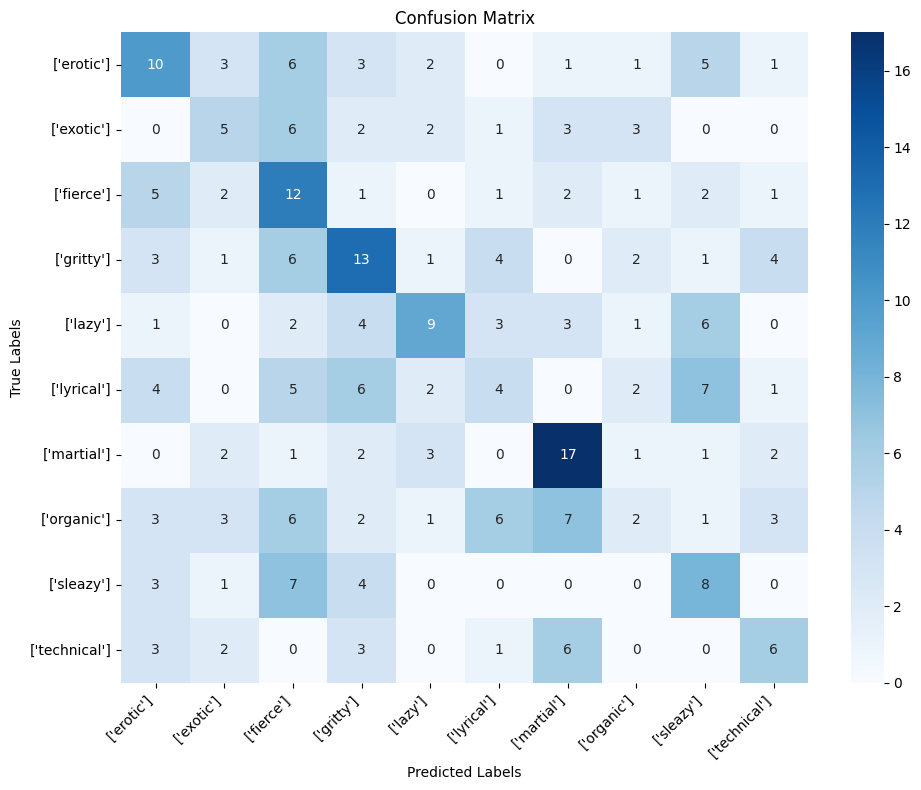

In [40]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

predicted_labels = []
true_labels = []

# Iterate over the test dataset
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    predicted_labels.extend(predictions.tolist())
    true_labels.extend(batch['labels'].tolist())

logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

predicted_labels = label_encoder.inverse_transform(predicted_labels)
true_labels = label_encoder.inverse_transform(true_labels)

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", ax=ax)

# Set labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(label_encoder.classes_, rotation=45, ha="right")
ax.set_yticklabels(label_encoder.classes_, rotation=0)

# Save the plot
plt.savefig('confusion_matrix.png')

# Show the plot
plt.tight_layout()
plt.show()

In [46]:
plt.savefig('conf_matrix.png')

<Figure size 640x480 with 0 Axes>

In [41]:
!cp -r /content/best_model /content/drive/MyDrive/best_model

# Inference

In [42]:
# Load the best model
best_model_dir = "/content/drive/MyDrive/best_model"
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(best_model_dir))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
device

device(type='cuda')

In [43]:
def classify_sentiment(text, tokenizer, model):
    print(f"Input is: {text}")

    # Tokenize the input text
    inputs = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')

    inputs = {key: val.to(model.device) for key, val in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    # Apply softmax to obtain probabilities
    probabilities = torch.softmax(logits, dim=-1)

    predicted_label = torch.argmax(probabilities, dim=-1).item()

    # Inverse transform the predicted label
    label = label_encoder.inverse_transform([predicted_label])[0]

    print(f"Predicted label is: {label}")

In [44]:
# Example inference
input_text = 'I dont want a lot for Christmas There is just one thing I need I dont care about the presents underneath the Christmas tree I just want you for my own More than you could ever know Make my wish come true All I want for Christmas is you Yeah'
predicted_label = classify_sentiment(input_text, tokenizer, model)

Input is: I dont want a lot for Christmas There is just one thing I need I dont care about the presents underneath the Christmas tree I just want you for my own More than you could ever know Make my wish come true All I want for Christmas is you Yeah
Predicted label is: ['erotic']
